In [1]:
%pip install -q git+https://github.com/VarunNSrivastava/ChromaLab

Note: you may need to restart the kernel to use updated packages.


In [2]:
from chromalab.observer import Observer
from chromalab.spectra import Spectra, Illuminant
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
%matplotlib widget

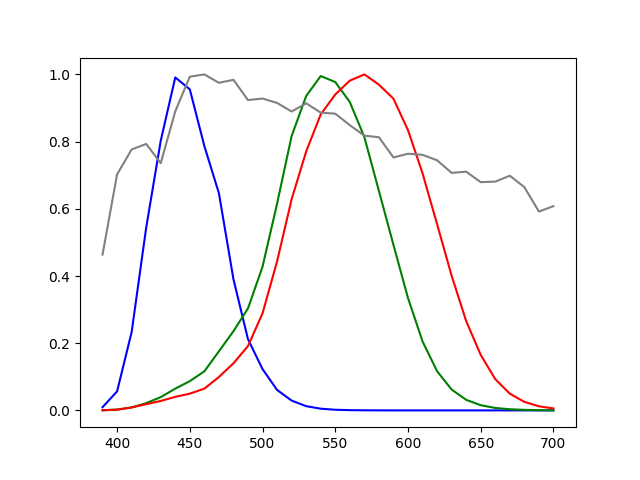

In [3]:
# Cone responses of a typical trichromat.
fig, ax = plt.subplots()
wavelengths = np.arange(390, 701, 10)
n = len(wavelengths)
standard_trichromat = Observer.trichromat(wavelengths)
illuminant = Illuminant.get("D65").interpolate_values(wavelengths)

standard_trichromat.sensors[0].plot(color="blue")
standard_trichromat.sensors[1].plot(color="green")
standard_trichromat.sensors[2].plot(color="red")
illuminant.plot(color="gray")

plt.show()

In [4]:
# Each point has an indicator reflectance function where R = 1 at a single wavelength and 0 elsewhere.
# These points can be thought of as vectors which form a (linearly dependent) basis.
# The Minkowski sum of these vectors span the object color solid.
# Each point in the solid can be represented as some (non-unique) linear combination of these vectors.
# This represents equations (9), (10), (11), (12), (13).
lms_responses = np.vstack((standard_trichromat.sensors[0].data, 
                           standard_trichromat.sensors[1].data, 
                           standard_trichromat.sensors[2].data)) * illuminant.data

points = np.copy(lms_responses).T

# As shown in Centore's paper, these vertices form the shape of the solid.
# This represents the matrix in (7).
vertices = np.zeros((n + 1, n, 3))
vertices_colors = np.zeros((n + 1, n, 3))
vertices_to_colors = {}
for i in range(1, n + 1):
    for j in range(n):
        vertices[i, j] = vertices[i - 1, j] + points[(i + j - 1) % n]
        reflectance_data = np.zeros(n)
        for k in range(i):
            reflectance_data[(j + k) % n] = 1
        reflectance = Spectra(wavelengths=wavelengths, data=reflectance_data)
        vertices_colors[i][j] = reflectance.to_rgb(illuminant)
        vertices_to_colors[tuple(vertices[i, j])] = vertices_colors[i][j]

# This represents the diagram in (8)
faces = np.zeros((n * (n - 1), 4, 3))
face_colors = np.zeros((n * (n - 1), 3))
for i in tqdm(range(1, n)):
    for j in range(n):
        faces[((i - 1) * n) + j, 0] = vertices[i, j]
        faces[((i - 1) * n) + j, 1] = vertices[i - 1, (j + 1) % n]
        faces[((i - 1) * n) + j, 2] = vertices[i, (j + 1) % n]
        faces[((i - 1) * n) + j, 3] = vertices[i + 1, j]
        
        # Calculate the reflectance on each face by using the reflectance of one of its vertices.
        # Since each vertex can be thought of as a linear combination of the basis vectors, 
        # the vertex's reflectance is the sum of reflectances of those vectors that made up the vertex.
        reflectance_data = np.zeros(n)
        for k in range(i):
            reflectance_data[(j + k) % n] = 1
        reflectance = Spectra(wavelengths=wavelengths, data=reflectance_data)
        face_colors[(i - 1) * n + j] = reflectance.to_rgb(illuminant)    # Bottleneck. Takes about 3ms. 

100%|██████████| 31/31 [00:03<00:00,  8.01it/s]


In [5]:
# Uses ideas from Jessica's paper, on chapter 3.2 The Max Basis.
# We use the cutpoints that Jessica shows to be optimal for the trichromatic case.
cutpoint_1 = 487
cutpoint_2 = 573
index_1 = None
index_2 = None
for i, wavelength in enumerate(wavelengths):
    if index_1 is None and wavelength > cutpoint_1:
        index_1 = i
    if index_2 is None and wavelength >= cutpoint_2:
        index_2 = i
        break

# We calculate the vectors p1, p2 and p3 as shown in the paper.
# We "project the partition into the cone response basis" by summing up all the lms_responses within each partition.
# Note that our earlier calculations for lms_responses includes the illuminant already.
p1 = np.sum(lms_responses[:, :index_1], axis=1).reshape((3, 1))
p2 = np.sum(lms_responses[:, index_1:index_2], axis=1).reshape((3, 1))
p3 = np.sum(lms_responses[:, index_2:], axis=1).reshape((3, 1))

# We then create a transformation matrix that maps p1 to (1, 0, 0), p2 to (0, 1, 0) and p3 to (1, 0, 0).
# p1, p2 and p3 correspond to the ideal R, G, B points on our object color solid, 
# and we are mapping them onto the R, G, B points on the RGB cube.
# We are essentially "stretching" our object color solid so that it approximates the RGB cube.
transformation_matrix = np.linalg.inv(np.hstack((p1, p2, p3)))
faces_transformed = np.matmul(faces, transformation_matrix.T)


# Create a dictionary to store the transformed vertices and their colors
transformed_vertices_to_colors = {}

# Loop through the vertices and apply the transformation, then store in the dictionary
for i in range(1, n + 1):
    for j in range(n):
        # Get the original vertex
        original_vertex = vertices[i, j]
        
        # Transform the vertex using the transformation matrix
        transformed_vertex = np.dot(original_vertex, transformation_matrix.T)
        
        # Get the corresponding color for this vertex
        vertex_color = vertices_colors[i, j]
        
        # Store the transformed vertex and color in the dictionary
        transformed_vertices_to_colors[tuple(transformed_vertex)] = vertex_color

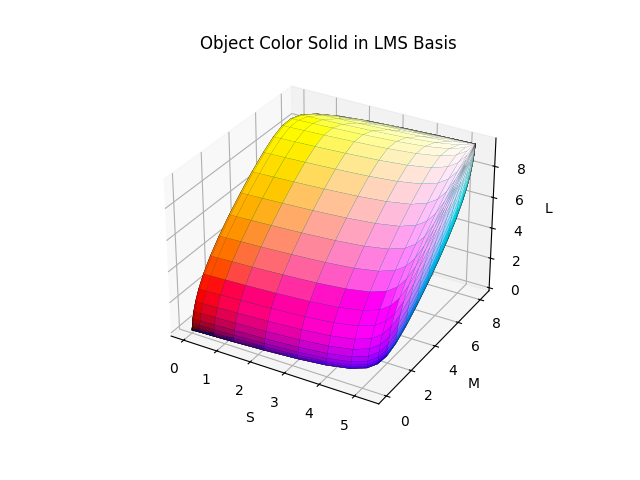

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
poly3d = Poly3DCollection(faces, linewidths=0.05, edgecolors='k')
poly3d.set_facecolor(face_colors)
ax.add_collection3d(poly3d)
ax.set_xlabel('S')
ax.set_ylabel('M')
ax.set_zlabel('L')
ax.set_title('Object Color Solid in LMS Basis')
plt.show()

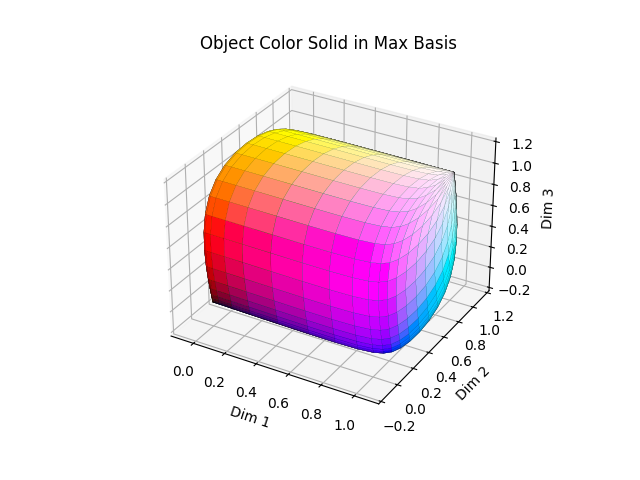

Pressed 'p' near face 564, vertices: [[ 0.44464504 -0.09873768  0.90266345]
 [ 0.44674721 -0.12377214  0.75341016]
 [ 0.64211184 -0.13415175  0.7590991 ]
 [ 0.64000967 -0.1091173   0.9083524 ]], colors: [ 1.          0.          0.64448792]
Vertex colors: [array([ 1.        ,  0.        ,  0.64448792]), array([ 1.        ,  0.        ,  0.65086311]), array([ 1.        ,  0.        ,  0.78918954]), array([ 1.        ,  0.        ,  0.78423823])]


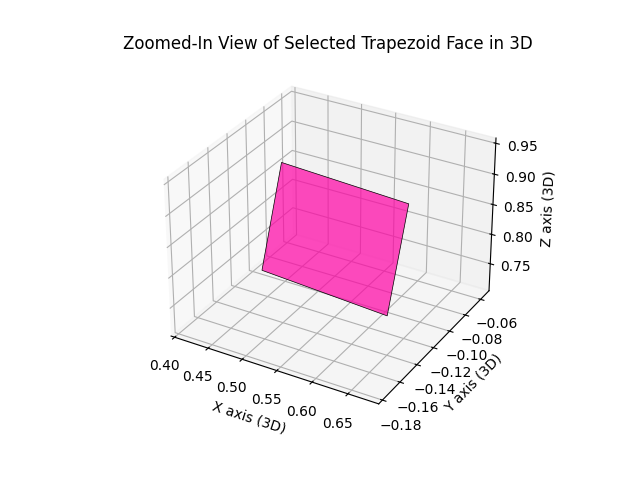

Pressed at approximate 3D coordinates: x=x=0.6273, y= y pane=−0.0487, z= z=0.8237
/nInterpolated color at the pressed point: [ 1.          0.          0.76881572]


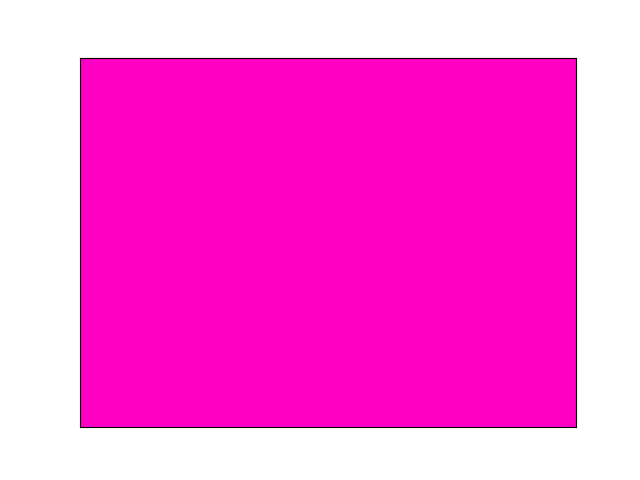

Pressed 'p' near face 960, vertices: [[ 0.9999735   1.00030797  0.99861776]
 [ 0.99905695  1.00041286  0.99852174]
 [ 0.99908345  1.00010489  0.99990398]
 [ 1.          1.          1.        ]], colors: [ 0.99804202  1.          1.        ]
Vertex colors: [array([ 0.99804202,  1.        ,  1.        ]), array([ 0.9978989 ,  1.        ,  0.99918952]), array([ 0.99978834,  1.        ,  0.99917688]), array([ 0.99993111,  1.        ,  1.        ])]


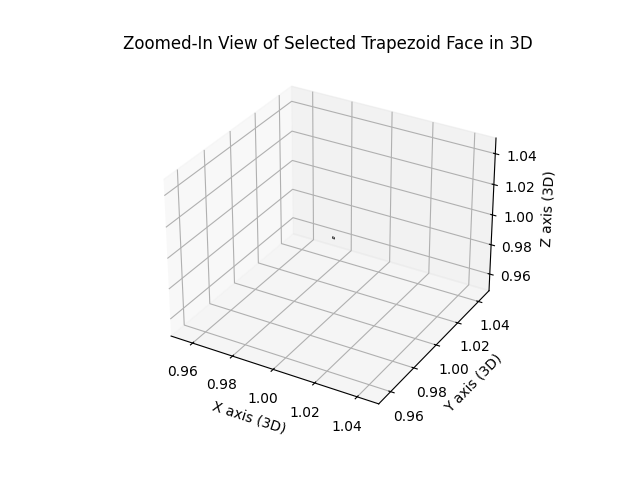

Pressed 'p' near face 392, vertices: [[ 0.19668221  1.13359684  0.24286262]
 [ 0.0688739   1.1174207   0.2547086 ]
 [ 0.06875785  1.11876486  0.42123324]
 [ 0.19656616  1.13494101  0.40938726]], colors: [ 0.          1.          0.50731144]
Vertex colors: [array([ 0.        ,  1.        ,  0.50731144]), array([ 0.        ,  1.        ,  0.29992669]), array([ 0.48792292,  1.        ,  0.28778773]), array([ 0.46952291,  1.        ,  0.50104052])]


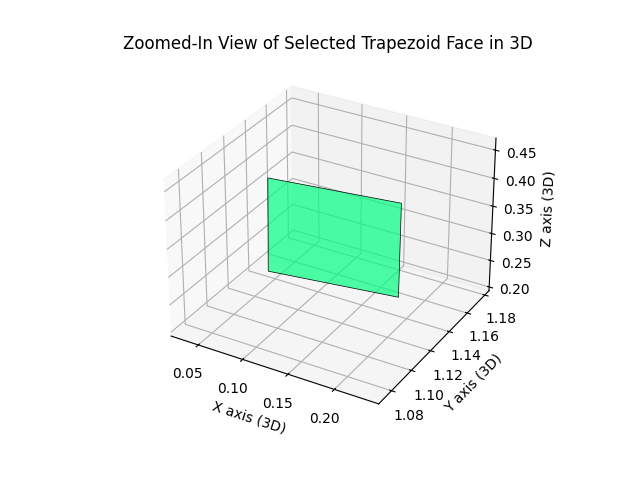

Pressed at approximate 3D coordinates: x=x=0.0610, y= y pane=1.1849, z= z=0.2180
/nInterpolated color at the pressed point: [-0.1057128   1.          0.30371264]


ValueError: RGBA values should be within 0-1 range

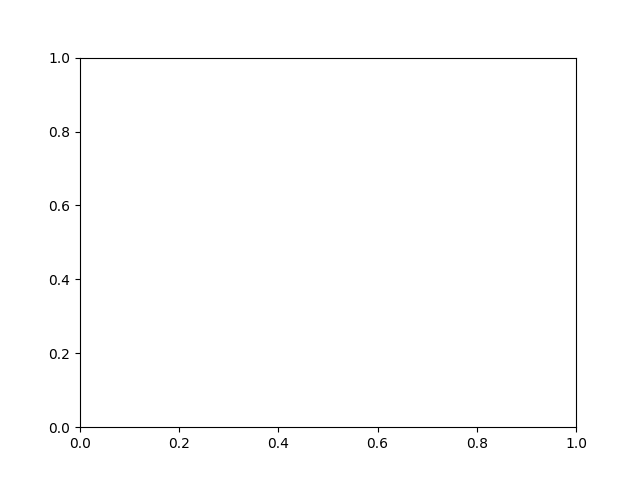

Pressed at approximate 3D coordinates: x=x=0.0335, y= y pane=1.1849, z= z=0.2518
/nInterpolated color at the pressed point: [-0.01216993  1.          0.25692971]


ValueError: RGBA values should be within 0-1 range

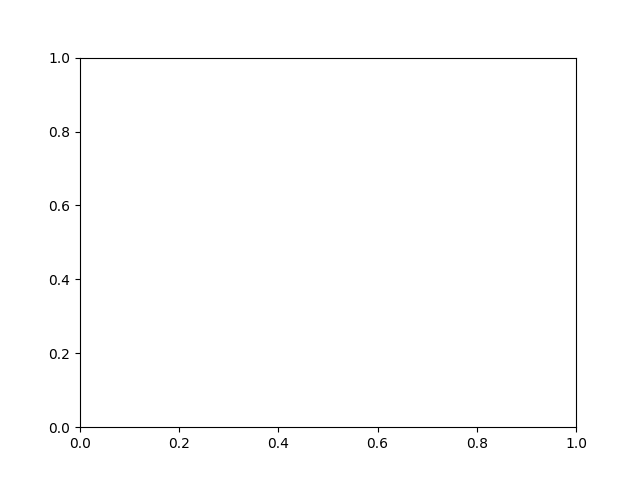

Pressed at approximate 3D coordinates: x=x=0.1379, y= y=1.0701, z= z pane=0.1929
/nInterpolated color at the pressed point: [-0.16428048  1.          0.40427137]


ValueError: RGBA values should be within 0-1 range

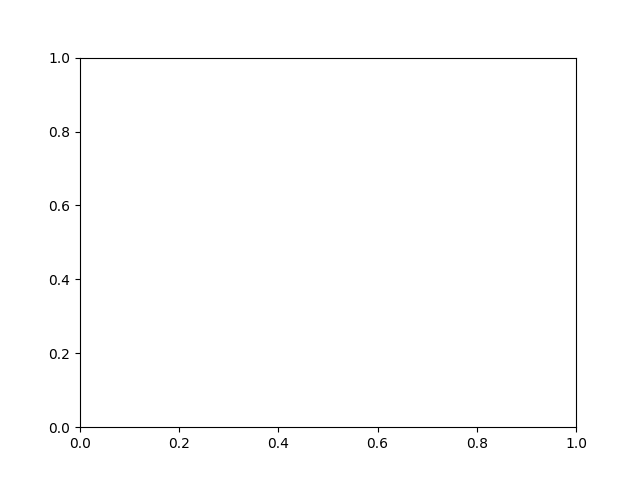

Pressed 'p' near face 57, vertices: [[ 0.00186073 -0.02217328  0.1108677 ]
 [ 0.00073152 -0.00871465  0.04195469]
 [ 0.00116556 -0.01388138  0.06598803]
 [ 0.00229477 -0.02734001  0.13490104]], colors: [ 0.4260327  0.         0.       ]
Vertex colors: [array([ 0.4260327,  0.       ,  0.       ]), array([ 0.26817579,  0.        ,  0.        ]), array([ 0.33653676,  0.        ,  0.        ]), array([ 0.46850796,  0.        ,  0.        ])]


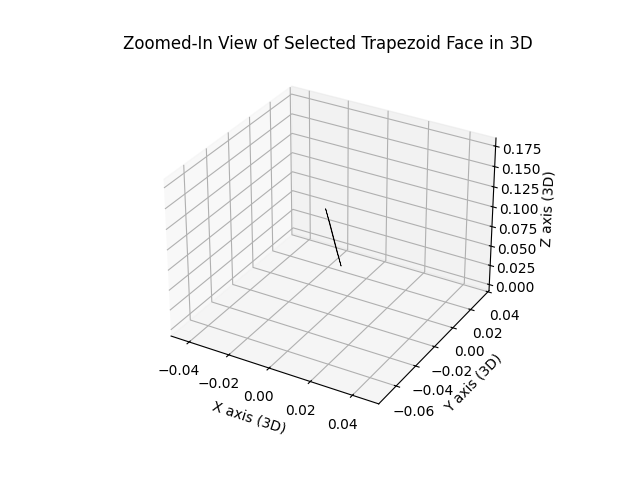

Pressed 'p' near face 299, vertices: [[-0.04290977  1.03349981  0.30343429]
 [-0.06020132  0.96113514  0.33734069]
 [-0.06031738  0.96247931  0.50386533]
 [-0.04302583  1.03484398  0.46995893]], colors: [ 0.30418371  1.          0.        ]
Vertex colors: [array([ 0.30418371,  1.        ,  0.        ]), array([ 0.40923249,  0.99048027,  0.        ]), array([ 0.62399022,  0.99655261,  0.        ]), array([ 0.56864327,  1.        ,  0.        ])]


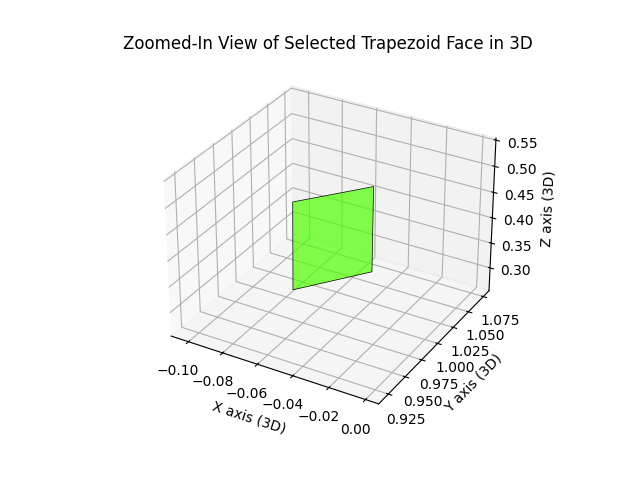

Pressed at approximate 3D coordinates: x=x pane=−0.1103, y= y=1.0690, z= z=0.3647
/nInterpolated color at the pressed point: [ 0.31726668  1.01325782  0.        ]


ValueError: RGBA values should be within 0-1 range

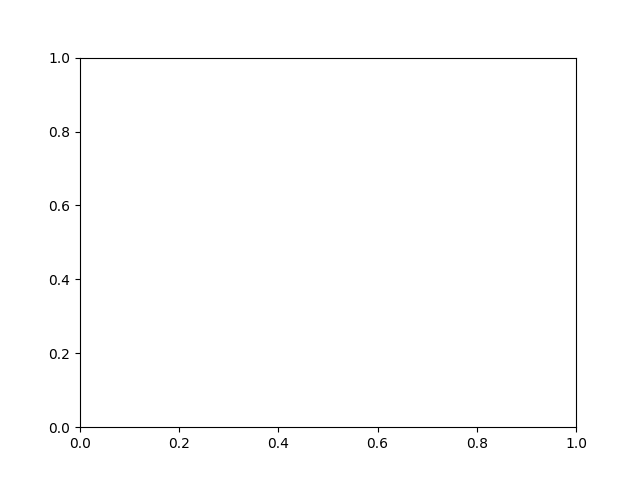

Pressed at approximate 3D coordinates: x=x pane=−0.1103, y= y=1.0535, z= z=0.3474
/nInterpolated color at the pressed point: [ 0.42728413  0.99580452  0.        ]


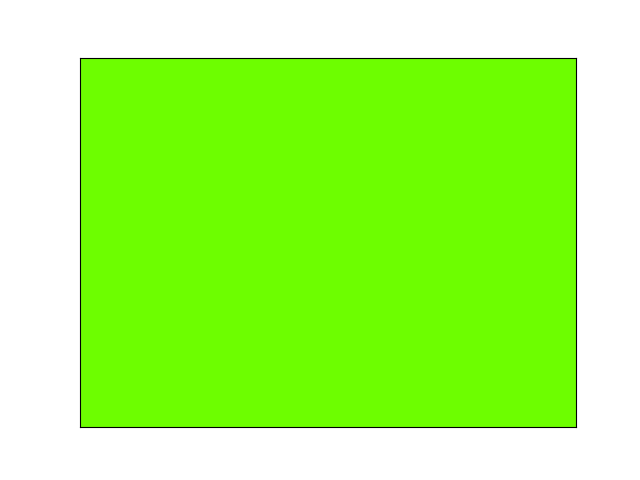

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import distance
import re

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
poly3d = Poly3DCollection(faces_transformed, linewidths=0.05, edgecolors='k', picker=True)
poly3d.set_facecolor(face_colors)
ax.add_collection3d(poly3d)

ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.set_title('Object Color Solid in Max Basis')

# Variable to store the current hover position
current_hover_position = None
zoomed_current_hover_position = None

to_convert = []

# Function to project 3D points to 2D (for distance calculation)
def project_3D_to_2D(points_3D):
    # Add an extra column of ones to convert to homogeneous coordinates (4D)
    ones_column = np.ones((points_3D.shape[0], 1))
    points_homogeneous = np.hstack((points_3D, ones_column))  # Shape (4, 4) for 4 points

    # Get the 4x4 transformation matrix for projection
    transform_matrix = ax.get_proj()

    # Perform the projection using the transformation matrix
    projected_points = np.dot(points_homogeneous, transform_matrix.T)

    # Normalize the projected points (convert from homogeneous back to 2D)
    projected_points[:, :2] /= projected_points[:, 3][:, np.newaxis]

    # Return the 2D points for plotting (ignore the z and w components)
    return projected_points[:, :2]

# Function to plot just the selected face in 3D and zoom in with the same color
def plot_face_3D(face_3D, face_color, vert_colors):
    fig_3D = plt.figure()
    ax_3D = fig_3D.add_subplot(111, projection='3d')
    
    # Create a Poly3DCollection for the selected face with the same color
    poly3d_face = Poly3DCollection([face_3D], linewidths=0.5, edgecolors='k', facecolor=face_color, alpha=0.7)
    ax_3D.add_collection3d(poly3d_face)
    
    # Set the axes limits to focus on the selected face (zoom in)
    ax_3D.set_xlim([np.min(face_3D[:, 0]) - 0.05, np.max(face_3D[:, 0]) + 0.05])
    ax_3D.set_ylim([np.min(face_3D[:, 1]) - 0.05, np.max(face_3D[:, 1]) + 0.05])
    ax_3D.set_zlim([np.min(face_3D[:, 2]) - 0.05, np.max(face_3D[:, 2]) + 0.05])

    ax_3D.set_xlabel('X axis (3D)')
    ax_3D.set_ylabel('Y axis (3D)')
    ax_3D.set_zlabel('Z axis (3D)')
    ax_3D.set_title('Zoomed-In View of Selected Trapezoid Face in 3D')

    # Function to handle clicks on the zoomed-in face and print coordinates
    def on_zoomed_face_click(event):
        if zoomed_current_hover_position is not None:
            x2D, y2D = zoomed_current_hover_position
            # Get the corresponding 3D coordinates using the zoomed-in axes
            x3D, y3D, z3D = ax_3D.format_coord(x2D, y2D).split(",")

            point_3D = np.array([float(re.sub('[^0-9,.,-]', '', x3D)), float(re.sub('[^0-9,.,-]', '', y3D)), float(re.sub('[^0-9,.,-]', '', z3D))])
            

            # face_vertex_colors = np.array([face_color[i] for i in range(4)]) 
            # interpolated_color = interpolate_color(bary_coords, face_vertex_colors)
            interpolated_color = project_and_interpolate_color(point_3D, face_3D, vert_colors)
            print(f"Pressed at approximate 3D coordinates: x={x3D}, y={y3D}, z={z3D}")
            print(f"/nInterpolated color at the pressed point: {interpolated_color}")
            plot_color_square(interpolated_color)
            


    # Event handler for hovering over the zoomed-in plot
    def on_zoomed_hover(event):
        global zoomed_current_hover_position
        if event.inaxes == ax_3D:  # Ensure the hover is within the zoomed-in axes
            x2D, y2D = event.xdata, event.ydata
            if x2D is not None and y2D is not None:
                zoomed_current_hover_position = (x2D, y2D)
    
    # Connect the click event for the zoomed-in face to the handler
    fig_3D.canvas.mpl_connect('motion_notify_event', lambda event: on_zoomed_hover(event))
    fig_3D.canvas.mpl_connect('key_press_event', lambda event: on_zoomed_face_click(event))
    
    plt.show()



# Function to find the nearest face to the hover position
def find_nearest_face(x2D, y2D):
    distances = []
    for i, face in enumerate(faces_transformed):
        # Project the 3D vertices of the face to 2D screen coordinates
        verts_2D = project_3D_to_2D(face)
        # Calculate the centroid of the face in 2D for comparison
        centroid_2D = np.mean(verts_2D, axis=0)
        dist = distance.euclidean((x2D, y2D), centroid_2D)
        distances.append((dist, i))
    # Return the index of the nearest face
    nearest_face_idx = min(distances, key=lambda x: x[0])[1]
    return nearest_face_idx

# Event handler for hovering over the plot
def on_hover(event):
    global current_hover_position
    if event.inaxes == ax:  # Ensure the hover is within the 3D axes
        x2D, y2D = event.xdata, event.ydata
        if x2D is not None and y2D is not None:
            current_hover_position = (x2D, y2D)

# Event handler for pressing the 'p' key and selecting the nearest face
def on_key_press(event):
    if event.key == 'p' and current_hover_position is not None:
        x2D, y2D = current_hover_position

        # Find the nearest face to the current hover position
        nearest_face_idx = find_nearest_face(x2D, y2D)
        face = faces_transformed[nearest_face_idx]
        face_color = face_colors[nearest_face_idx]
        vert_colors = []
        for vert in face:
            vert_colors.append(transformed_vertices_to_colors[tuple(vert)])
        
        # Print the vertices of the selected face
        print(f"Pressed 'p' near face {nearest_face_idx}, vertices: {face}, colors: {face_color}")
        print(f"Vertex colors: {vert_colors}")
        
        # Plot the selected face in 3D with zoom and original color
        plot_face_3D(face, face_color, vert_colors)

def project_point_onto_plane(point_3D, face_vertices):
    """
    Projects a 3D point onto the plane defined by the quadrilateral face.

    Parameters:
    point_3D: numpy array of shape (3,), the 3D point to project.
    face_vertices: numpy array of shape (4, 3), the four vertices of the quadrilateral face.

    Returns:
    The 3D point projected onto the plane of the face.
    """
    # Use the first three vertices to define the plane
    v0, v1, v2, _ = face_vertices

    # Compute two edges of the face to define the plane
    edge1 = v1 - v0
    edge2 = v2 - v0

    # Compute the normal vector of the plane using the cross product
    normal_vector = np.cross(edge1, edge2)

    # Normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)

    # Vector from v0 to the point
    v0_to_point = point_3D - v0

    # Distance from point to the plane (dot product of v0_to_point and normal vector)
    distance_to_plane = np.dot(v0_to_point, normal_vector)

    # Project the point onto the plane
    projected_point = point_3D - distance_to_plane * normal_vector

    return projected_point


def project_and_interpolate_color(point_3D, face_vertices, vertex_colors):
    """
    Project a 3D point onto a quadrilateral face, compute its barycentric coordinates,
    and interpolate the color at that point based on the vertex colors.

    Parameters:
    point_3D: numpy array of shape (3,), the 3D point to project and interpolate.
    face_vertices: numpy array of shape (4, 3), the vertices of the quadrilateral face.
    vertex_colors: numpy array of shape (4, 3), the colors (RGB) at the four vertices.

    Returns:
    Interpolated color as a numpy array of shape (3,) representing the RGB value.
    """

    # Step 1: Project the 3D point onto the plane of the face
    projected_point = project_point_onto_plane(point_3D, face_vertices)

    # Step 2: Compute barycentric coordinates of the projected point with respect to the face
    bary_coords = compute_barycentric_coordinates(projected_point, face_vertices)

    # Step 3: Interpolate the color at the projected point using barycentric coordinates
    interpolated_color = interpolate_color(bary_coords, vertex_colors)

    return interpolated_color



def compute_barycentric_coordinates(point, face_vertices):
    """
    Calculate the barycentric coordinates of a 3D point with respect to a quadrilateral face.

    Parameters:
    point: numpy array of shape (3,), the 3D point.
    face_vertices: numpy array of shape (4, 3), the four vertices of the quadrilateral face.

    Returns:
    Barycentric coordinates as a numpy array of shape (4,).
    """
    # The four vertices of the face
    v0, v1, v2, v3 = face_vertices

    # Compute vectors from one vertex (v0) to the others
    v0v1 = v1 - v0
    v0v2 = v2 - v0
    v0v3 = v3 - v0
    v0p = point - v0  # Vector from v0 to the point

    # Set up a matrix of the vectors
    M = np.array([v0v1, v0v2, v0v3]).T

    # Solve the system of linear equations: M * [u, v, w].T = v0p
    u, v, w = np.linalg.solve(M, v0p)

    # Compute the fourth barycentric coordinate
    b0 = 1 - u - v - w
    b1, b2, b3 = u, v, w

    # print(f"Barycentric coordinates of the pressed point: {bary_coords}")


    return np.array([b0, b1, b2, b3])

def interpolate_color(barycentric_coords, vertex_colors):
    """
    Interpolates the color at a point on the face using barycentric coordinates.

    Parameters:
    barycentric_coords: numpy array of shape (4,), the barycentric coordinates of the point.
    vertex_colors: numpy array of shape (4, 3), the RGB colors at the four vertices.

    Returns:
    Interpolated color as a numpy array of shape (3,) representing the RGB value.
    """
    # Each vertex color is weighted by its corresponding barycentric coordinate
    interpolated_color = np.dot(barycentric_coords, vertex_colors)
    
    return interpolated_color

def plot_color_square(interpolated_color):
    """
    Plots a square image filled with the interpolated color.

    Parameters:
    interpolated_color: numpy array of shape (3,), the RGB color to fill the square with.
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the background color to the interpolated color
    ax.set_facecolor(interpolated_color)

    to_convert.append(interpolated_color)

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Set the axis limits to make it a square
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # Display the square
    plt.show()

# Connect the hover and key press events to their respective handlers
fig.canvas.mpl_connect('motion_notify_event', on_hover)
fig.canvas.mpl_connect('key_press_event', on_key_press)

plt.show()


[ 1.          0.          0.76881572]
[-0.03935025  0.          0.76881572]


/var/folders/sx/7pc_91_j5ng3gll1f09nj0tr0000gn/T/ipykernel_72604/401167437.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


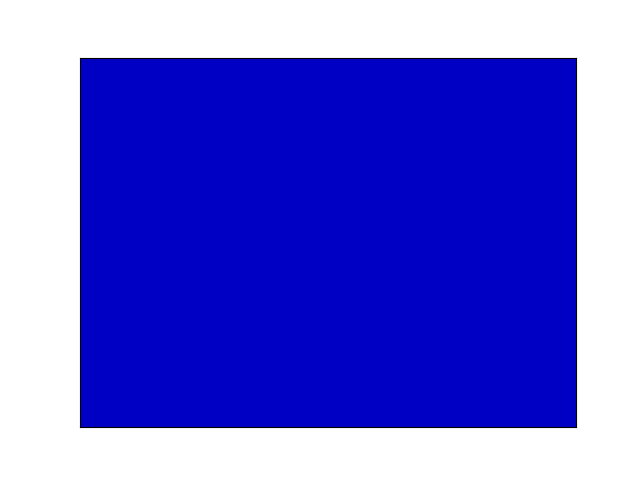

[ 0.42728413  0.99580452  0.        ]
[ 1.04677273  0.99580452  0.        ]


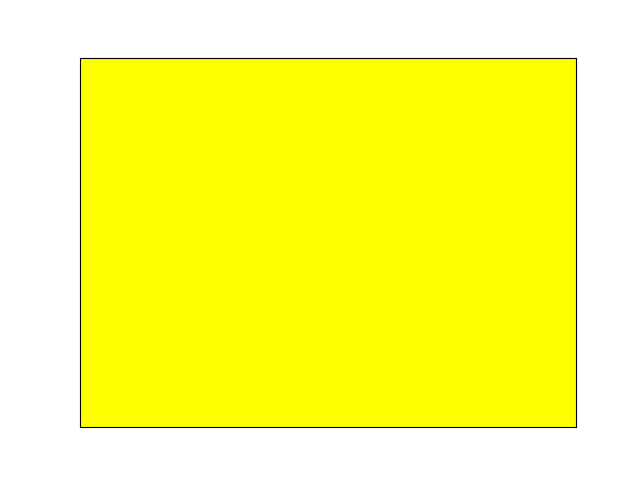

In [16]:
import numpy as np

def dichromat_cmf(type="protan"):
    """
    Returns the color matching function matrix for a given dichromat type.
    
    Args:
        type (str): The type of dichromacy ("protan", "deutan", or "tritan").
    
    Returns:
        numpy.ndarray: The 3x3 color matching function matrix.
    """

    if type == "protan":
        # Transformation matrix for protanopia (source: Brettel et al., 1997)
        matrix = np.array([
            [0.0, 1.05118294, -0.05118294],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, 1.0],
        ])
    elif type == "deutan":
        # Transformation matrix for deuteranopia (source: Brettel et al., 1997)
        matrix = np.array([
            [1.0, 0.0, 0.0],
            [0.9513092, 0.0, 0.0486908],
            [0.0, 0.0, 1.0],
        ])
    elif type == "tritan":
        # Transformation matrix for tritanopia (source: Brettel et al., 1997)
        matrix = np.array([
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [-0.86744736, 1.86744736, 0.0],
        ])
    else:
        raise ValueError("Invalid dichromat type. Choose from 'protan', 'deutan', or 'tritan'.")

    return matrix

def plot_color(interpolated_color):
    """
    Plots a square image filled with the interpolated color.

    Parameters:
    interpolated_color: numpy array of shape (3,), the RGB color to fill the square with.
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the background color to the interpolated color
    ax.set_facecolor(interpolated_color)

    # Remove ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Set the axis limits to make it a square
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # Display the square
    plt.show()

# Example usage:
converted = []
for c in to_convert:
    print(c)
    rgb_color = np.array(c) # Example RGB color
    protan_cmf = dichromat_cmf("protan")
    protan_color = protan_cmf @ rgb_color 
    print(protan_color)
    protan_color = np.where(protan_color < 0, 0, protan_color)
    protan_color = np.where(protan_color > 1, 1, protan_color)
    plot_color(protan_color)
    converted.append(protan_color)